## Machine specific data

In [1]:
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

## Imports

In [2]:
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import sys
from math import log

sys.path.append(PSIS_DIRECTORY)
import psis

## Load data

In [3]:
with open(DATA_PATH) as file:
    data = json.load(file)

In [4]:
print(data[0].keys())

dict_keys(['asa', 'desc', 'disorder', 'epitope', 'id', 'interface', 'method', 'phi', 'preds', 'psi', 'q3', 'q3_prob', 'q8', 'q8_prob', 'rsa', 'seq'])


In [5]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

In [6]:
# Remove X from protein
for protein in data:
    if 'X' in protein['seq']:
        x_positions = [i for i,n in enumerate(protein['seq']) if n == 'X']
        for k, v in protein.items():
            if not hasattr(v, "__len__") or len(v) != len(protein['seq']):
                continue
            newdata = [x for i,x in enumerate(v) if i not in x_positions]
            if isinstance(v, str):
                newdata = ''.join(newdata)
            protein[k] = newdata

## Null model

In [19]:
n_epitopes = sum(sum(protein['epitope']) for protein in data)
total_aminoacids = sum(len(protein['epitope']) for protein in data)
logps = np.array([log(1 - n_epitopes / total_aminoacids), log(n_epitopes / total_aminoacids)])
model_null_loglik = sum(logps[np.array(protein['epitope'])].sum() for protein in data)
model_null_loglik

-13544.838853581236

## Model 0:

Interpret BepiPred output as probabilities

In [21]:
epitopes = np.empty(total_aminoacids, dtype=np.int32)
scores = np.empty(total_aminoacids, dtype=np.float32)

index = 0
for protein in data:
    length = len(protein['epitope'])
    epitopes[index:index+length] = protein['epitope']
    scores[index:index+length] = protein['preds']
    index += length
    
model_0_loglik = np.empty((1, len(scores)), dtype=np.float32)
mask = epitopes == 1
model_0_loglik[0, mask] = np.log(scores[mask])
model_0_loglik[0, ~mask] = np.log(1 - scores[~mask])

# No sampling, so we use the loglikelihood
model_0_loglik.sum()

-12883.652

## Model 1:

Epitope status calculated as logistic regression of prediction:

$ep = logit^{-1}(\alpha + \beta * pred)$

In [13]:
with open('models/pooled.stan') as f:
    model_1_code = f.read()

In [15]:
epitopes = np.empty(total_aminoacids, dtype=np.int32)
scores = np.empty(total_aminoacids, dtype=np.float32)

index = 0
for protein in data:
    length = len(protein['epitope'])
    epitopes[index:index+length] = protein['epitope']
    scores[index:index+length] = protein['preds']
    index += length
    
standata_1 = {'total_aa': total_aminoacids,
        'epitopes': epitopes,
        'scores': scores
       }

In [16]:
model_1 = pystan.StanModel(model_code=model_1_code, model_name='Model_1')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_1_15dac7ff361ffbd44467ef7cae14a597 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp03kkz0s6/stanfit4Model_1_15dac7ff361ffbd44467ef7cae14a597_888587013372514854.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [17]:
fit_1 = model_1.sampling(data=standata_1)

In [22]:
print(fit_1)

Inference for Stan model: Model_1_15dac7ff361ffbd44467ef7cae14a597.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
params[1]  -3.58  1.5e-3   0.04  -3.66   -3.6  -3.58  -3.55   -3.5    787    1.0
params[2]  12.63    0.01   0.38  11.91  12.37  12.63  12.87   13.4    794    1.0
lp__      -1.3e4    0.03   1.06 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1073    1.0

Samples were drawn using NUTS at Wed May  8 10:54:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [23]:
# Calculate PSIS LOO
extract_1 = fit_1.extract()
n_obs = len(extract_1['params'])
model_1_loglik = np.empty((n_obs, standata_1['total_aa']), dtype=np.float32)
mask = standata_1['epitopes'] == 1
for i in range(n_obs):
    a, b = extract_1['params'][i]
    ps = expit(a + b*standata_1['scores'])
    ps[~mask] = 1-ps[~mask]
    model_1_loglik[i] = np.log(ps)

In [24]:
model_1_loo, model_1_loos, model_1_ks = psis.psisloo(model_1_loglik)
print(model_1_loo)

-12992.173


## Model 2

Hierarchical model distributing over the 20 amino acids: B[aa] ~N(m, s); p ~ expit(B[aa] + a*preds)

In [26]:
with open('models/hierarchical.stan') as file:
    model_2_code = file.read()

In [27]:
model_2 = pystan.StanModel(model_code=model_2_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_841b9fd48e668bce07c190a6b29a43a7 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp2rvvvrw2/stanfit4anon_model_841b9fd48e668bce07c190a6b29a43a7_6356699967924853346.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [28]:
aaset = set()
for protein in data:
    aaset.update(set(protein['seq']))
aaindex = {aa:i+1 for i, aa in enumerate(aaset)} # STAN is 1-indexed
i = 0
aas = np.empty_like(scores, dtype=np.int32)
for protein in data:
    aas[i:i+len(protein['seq'])] = [aaindex[i] for i in protein['seq']]
    i += len(protein['seq'])
    
classes = len(aaset)

standata = {'total_aa': total_aminoacids,
            'epitopes': epitopes,
            'scores': scores,
            'aa':aas,
            'classes': classes
            }

In [29]:
fit_model_2 = model_2.sampling(data=standata)
print(fit_model_2)

Inference for Stan model: anon_model_841b9fd48e668bce07c190a6b29a43a7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_mu     -3.57  1.6e-3   0.05  -3.66   -3.6  -3.57  -3.53  -3.47    839    1.0
beta_sigma   0.09  9.7e-4   0.03   0.04   0.07   0.09   0.11   0.16    959    1.0
alpha       12.55    0.01   0.39  11.78  12.29  12.55  12.81  13.33    843    1.0
beta[1]     -3.66  2.0e-3   0.09  -3.86  -3.72  -3.65   -3.6   -3.5   2220    1.0
beta[2]     -3.67  1.6e-3   0.07  -3.81  -3.71  -3.66  -3.62  -3.53   1948    1.0
beta[3]     -3.66  1.5e-3   0.07   -3.8  -3.71  -3.66  -3.62  -3.54   1916    1.0
beta[4]     -3.59  1.5e-3   0.07  -3.73  -3.64  -3.59  -3.54  -3.47   1910    1.0
beta[5]     -3.66  1.9e-3   0.07   -3.8  -3.71  -3.66  -3.61  -3.52   1388    1.0
beta[6]     -3.51  1.8e-3   0.07  -3.65  -3.56  -3.51  -3.46  -3.36   163

In [31]:
# Calculate PSIS LOO
extract_2 = fit_model_2.extract()
n_obs = len(extract_1['params'])
model_2_loglik = np.empty((n_obs, standata['total_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_2['beta'][i][standata['aa'] - 1]
    alpha = extract_2['alpha'][i]
    ps = expit(beta + alpha*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    model_2_loglik[i] = np.log(ps)

In [32]:
model_2_loo, model_2_loos, model_2_ks = psis.psisloo(model_2_loglik)
print(model_2_loo)

-12986.496


## Model 4

p ~ expit(a + b*pred + c/length * pred)

In [33]:
with open("models/length.stan") as file:
    model_4_code = file.read()

In [34]:
model_4 = pystan.StanModel(model_code=model_4_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6af29b92d2f70b85ab0d7a1cb227130d NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp_tk3wn17/stanfit4anon_model_6af29b92d2f70b85ab0d7a1cb227130d_7700698942508902993.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [35]:
inv_lens = np.empty(len(standata['aa']), dtype=np.float)
index = 0
for protein in data:
    length = len(protein['seq'])
    inv_lens[index:index+length] = 1/length
    index += length
    
standata['inv_length'] = inv_lens

In [36]:
fit_model_4 = model_4.sampling(data=standata)
print(fit_model_4)

Inference for Stan model: anon_model_6af29b92d2f70b85ab0d7a1cb227130d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_mu     -4.11  2.3e-3   0.06  -4.23  -4.15  -4.11  -4.07   -4.0    639   1.01
beta_sigma   0.14  7.6e-4   0.04   0.07   0.11   0.13   0.16   0.22   2211    1.0
alpha        9.73    0.01   0.44   8.85   9.43   9.74  10.02  10.57    994   1.01
beta[1]     -4.32  2.3e-3   0.12  -4.56  -4.39  -4.31  -4.24  -4.11   2572    1.0
beta[2]     -4.31  1.9e-3   0.09  -4.48  -4.36   -4.3  -4.25  -4.15   1989    1.0
beta[3]     -4.26  1.8e-3   0.07  -4.41  -4.31  -4.26  -4.21  -4.12   1645    1.0
beta[4]     -4.16  2.0e-3   0.08  -4.32  -4.22  -4.16  -4.11  -4.02   1555    1.0
beta[5]     -4.18  2.4e-3   0.08  -4.34  -4.24  -4.18  -4.13  -4.02   1188    1.0
beta[6]     -4.02  2.3e-3   0.09  -4.18  -4.07  -4.01  -3.96  -3.85   134

In [37]:
# Calculate PSIS LOO
extract_4 = fit_model_4.extract()
n_obs = len(extract_4['gamma'])
model_4_loglik = np.empty((n_obs, standata['total_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_4['beta'][i][standata['aa'] - 1]
    alpha = extract_4['alpha'][i]
    gamma = extract_4['gamma'][i]
    ps = expit(beta + alpha*standata['scores'] + gamma*standata['inv_length'])
    ps[~mask] = 1-ps[~mask]
    model_4_loglik[i] = np.log(ps)

In [38]:
model_4_loo, model_4_loos, model_4_ks = psis.psisloo(model_4_loglik)
print(model_4_loo)

-12578.548


## Model 5

p ~ expit(a + b*pred + c/score * pred)

In [39]:
with open("models/scores.stan") as file:
    model_5_code = file.read()

In [40]:
model_5 = pystan.StanModel(model_code=model_5_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bf1d1c5f20551b2c4a3cd740573ced8 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpavbx50nn/stanfit4anon_model_4bf1d1c5f20551b2c4a3cd740573ced8_11497605325800086.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [41]:
scoresums = np.empty(len(standata['aa']), dtype=np.float)
index = 0
for protein in data:
    length = len(protein['seq'])
    scoresum = sum(protein['preds'])
    scoresums[index:index+length] = 1/scoresum
    index += length
standata['inv_scores'] = scoresums

In [42]:
fit_model_5 = model_5.sampling(data=standata)
print(fit_model_5)

Inference for Stan model: anon_model_4bf1d1c5f20551b2c4a3cd740573ced8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_mu     -4.45  2.2e-3   0.06  -4.57  -4.49  -4.45  -4.42  -4.33    760    1.0
beta_sigma   0.13  8.1e-4   0.03   0.07    0.1   0.12   0.15    0.2   1845    1.0
alpha       10.54    0.01   0.43   9.68  10.26  10.54  10.82  11.37   1183    1.0
beta[1]     -4.63  2.6e-3   0.12  -4.87  -4.71  -4.62  -4.55  -4.42   2055    1.0
beta[2]     -4.63  2.2e-3   0.08  -4.79  -4.68  -4.62  -4.57  -4.47   1424    1.0
beta[3]      -4.6  2.1e-3   0.08  -4.76  -4.65   -4.6  -4.55  -4.45   1329    1.0
beta[4]      -4.5  2.3e-3   0.08  -4.66  -4.55   -4.5  -4.44  -4.34   1214    1.0
beta[5]     -4.53  2.5e-3   0.08  -4.69  -4.58  -4.53  -4.48  -4.37   1070    1.0
beta[6]     -4.38  2.5e-3   0.09  -4.54  -4.43  -4.37  -4.32   -4.2   122

In [43]:
# Calculate PSIS LOO
extract_5 = fit_model_5.extract()
n_obs = len(extract_5['gamma'])
model_5_loglik = np.empty((n_obs, standata['total_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_5['beta'][i][standata['aa'] - 1]
    alpha = extract_5['alpha'][i]
    gamma = extract_5['gamma'][i]
    ps = expit(beta + alpha*standata['scores'] + gamma*standata['inv_scores'])
    ps[~mask] = 1-ps[~mask]
    model_5_loglik[i] = np.log(ps)

In [44]:
model_5_loo, model_5_loos, model_5_ks = psis.psisloo(model_5_loglik)
model_5_loo

-12546.327

## Model 6
Same as model 5, but with a separate instead of pooled model

In [64]:
with open("models/separate_scoresum.stan") as file:
    model_6_code = file.read()

In [65]:
model_6 = pystan.StanModel(model_code=model_6_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f212c311e7bd6a37c064dee07eb46fd NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpot036qdx/stanfit4anon_model_1f212c311e7bd6a37c064dee07eb46fd_4939694452881583531.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [66]:
fit_model_6 = model_6.sampling(data=standata)
print(fit_model_6)

Inference for Stan model: anon_model_1f212c311e7bd6a37c064dee07eb46fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   14.38    0.07   5.92   2.72  10.49  14.45  18.25  26.13   6645    1.0
alpha[2]   12.31    0.03   2.04   8.43  10.91  12.28  13.75  16.24   6531    1.0
alpha[3]   16.68    0.02   1.74  13.27  15.48   16.7  17.86  20.03   7036    1.0
alpha[4]   10.63    0.02   1.81   7.05   9.45  10.63  11.87  14.31   5839    1.0
alpha[5]    7.58    0.02   1.55   4.53   6.55   7.57   8.62  10.64   6497    1.0
alpha[6]    7.71    0.02   1.78   4.22    6.5    7.7    8.9  11.26   6675    1.0
alpha[7]    8.24    0.02   1.72   4.95   7.07   8.23   9.45  11.65   5971    1.0
alpha[8]    8.59    0.02    1.7   5.32   7.45   8.59   9.72  11.95   6950    1.0
alpha[9]   14.22    0.02   1.76  10.82  13.01  14.21   15.4   17.6   7195    1.0
a

In [67]:
# Calculate PSIS LOO
extract_6 = fit_model_6.extract()
n_obs = len(extract_6['gamma'])
model_6_loglik = np.empty((n_obs, standata['total_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_6['beta'][i][standata['aa'] - 1]
    alpha = extract_6['alpha'][i][standata['aa'] - 1]
    gamma = extract_6['gamma'][i]
    ps = expit(beta + alpha*standata['scores'] + gamma*standata['inv_scores'])
    ps[~mask] = 1-ps[~mask]
    model_6_loglik[i] = np.log(ps)

In [68]:
model_6_loo, model_6_loos, model_6_ks = psis.psisloo(model_6_loglik)
model_6_loo

-12538.548

In [76]:
with open("models/inverse.stan") as file:
    model_7_code = file.read()

In [77]:
model_7 = pystan.StanModel(model_code=model_7_code)

ValueError: Failed to parse Stan model 'anon_model_c65d35b2cf7b46515efafb764f898779'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  expit(vector)

Function expit not found.
  error in 'unknown file name' at line 18, column 105
  -------------------------------------------------
    16: }
    17: model {
    18:     epitopes ~ uniform(gamma + (1 - gamma) * delta * inv_scores .* expit(beta[aa] + alpha[aa] .* scores));
                                                                                                                ^
    19: }
  -------------------------------------------------



In [75]:
logit(0.4)

-0.4054651081081643

##### print(h_loo)

In [112]:
def calc_peff(loglik, loo):
    likelihood = np.exp(loglik)
    observationwise_mean = likelihood.mean(axis=0)
    lppd = np.log(observationwise_mean).sum()
    return lppd - loo

In [113]:
calc_peff(pooled_loglik, pooled_loo), calc_peff(h_loglik, h_loo)

(1.5838013, 7.022003)

In [92]:
extract = fit2.extract()
extract['beta'][i][standata['aa'] - 1]

array([-8.81037531, -8.29491075, -8.16511506, ..., -8.20625734,
       -8.00648846, -8.39737347])

In [79]:
standata['aa'].max()

21

In [75]:
extract = fit2.extract()

In [76]:
extract.keys()

odict_keys(['beta_mu', 'beta_sigma', 'alpha', 'beta', 'lp__'])

In [82]:
extract['beta'].shape

(4000, 21)

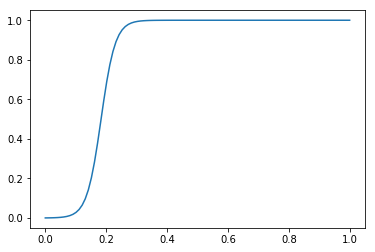

In [121]:
xs = np.linspace(0, 1, 100)
ys = expit(-7.87 + 42.94*xs)
plt.plot(xs, ys)

In [ ]:
for i in 

In [122]:
ps

array([0.99974536, 0.99955155, 0.99955443, ..., 0.99972713, 0.99966682,
       0.99977459])

In [123]:
mask

array([False, False, False, ..., False, False, False])

In [145]:
expit(-7.87 + 42.94*standata['scores'].min())

0.0003818884676828639

In [142]:
standata['scores'][mask].max()

0.15529731

In [143]:
standata['scores'][~mask].max()

0.20328818

In [146]:
from random import randint

In [158]:
n_sims = 100000
fewer = 0
for i in range(n_sims):
    females = np.random.randint(2, size=39).sum()
    if females <= 15:
        fewer += 1
print(fewer/n_sims)

0.0994


In [159]:
from scipy.special import binom

In [163]:
from scipy import stats

In [166]:
stats.binom.cdf(15, 39, 0.5)

0.09979543345980334

In [80]:

with open("models/hierarchical.stan") as file:
    print(file.read())

data {
    int<lower=0> classes;
    int<lower=0> total_aa;
    int aa[total_aa];
    int<lower=0,upper=1> epitopes[total_aa]; // binarize to 0 or 1
    vector[total_aa] scores; // output of bepipred
    
}
parameters {
    real beta_mu;
    real<lower=0> beta_sigma;
    real alpha;
    vector[classes] beta;
    
}
model {
    beta ~ normal(beta_mu, beta_sigma);
    epitopes ~ bernoulli_logit(beta[aa] + alpha*scores);
}



In [135]:
a = np.random.random((8, 3))
a

array([[0.74471047, 0.74963462, 0.16122966],
       [0.96892623, 0.29223294, 0.15433968],
       [0.88539097, 0.70576973, 0.45486873],
       [0.23513107, 0.93509444, 0.46100916],
       [0.95243191, 0.06529304, 0.64825642],
       [0.79607868, 0.89660818, 0.28714443],
       [0.5200085 , 0.36927028, 0.15267444],
       [0.65009486, 0.46175046, 0.82713889]])

In [136]:
np.random.RandomState(0).shuffle(a)
indices = np.random.RandomState(0).permutation(len(a))

In [137]:
a

array([[0.5200085 , 0.36927028, 0.15267444],
       [0.88539097, 0.70576973, 0.45486873],
       [0.96892623, 0.29223294, 0.15433968],
       [0.65009486, 0.46175046, 0.82713889],
       [0.23513107, 0.93509444, 0.46100916],
       [0.74471047, 0.74963462, 0.16122966],
       [0.79607868, 0.89660818, 0.28714443],
       [0.95243191, 0.06529304, 0.64825642]])

In [138]:
indices

array([6, 2, 1, 7, 3, 0, 5, 4])

In [144]:
np.array([2,3,3,6,7,8])[np.array([3,2,1])]

array([6, 3, 3])

In [145]:
data

array([21,  9,  5, ..., 19,  5,  1], dtype=int32)

In [69]:
data[0]['disorder'][:3]

[0.6973695158958435, 0.5611188411712646, 0.3760852515697479]

In [149]:
data[-1]['seq'][-3:]

'ALK'

In [150]:
["A", "K", "L"]
[19, 5, 1]

[my_dict[i] for i in protein['seq']]

[19, 5, 1]

In [157]:
dict_ = {1:2, 2:1, 3:3}

In [158]:
[dict_[i] for i in [1,2,3]]

[2, 1, 3]

In [ ]:
all_aas = set()
for protein in proteins:
    all_aas |= set(protein['seq'])
my_dict = {j:i+1 for i,j in enumerate(all_aas)}

In [168]:
var_set = var_set.union(set(x))

NameError: name 'var_set' is not defined

In [225]:
import sys

In [226]:
sys.path.append("/Users/jakni/Documents/scripts/vamb")
import vamb

ModuleNotFoundError: No module named 'pysam'

In [58]:
len(list(data[0].keys()))

16

In [61]:
data[1]['q3']

'CCCCCCCCCCCCEEEEECCCCHHHHCCCCCCCEEEEECCEECCCHHHHHHHHHHHHHCCCCCEEEEEEECCEEEEEEEECCCCCCCCCCCECCCCCCEEEEECCCCHHHHCCCCCCCEEEEECCEECCCHHHHHHHHHHCCCCCEEEEEEECCEEEEEEEEEEECCCCCEEEEEEEECCC'